In [70]:
import pandas as pd
import os.path
import numpy as np
import PIL
import glob
from PIL import Image

In [71]:
os.chdir('/Users/KevinBu/Desktop/clemente_lab/CUTIE/')
stat_df = pd.read_csv('scripts/figures/stat_dict.txt', sep = '\t')
rev_stat_df = pd.read_csv('scripts/figures/rev_stat_dict.txt', sep = '\t')
stat_df.head()

,statistic,cutie,jackknifing,bootstrapping,cooks_d
0,pearson,kpc,jkp,bsp,pointwise_kpc
1,spearman,ksc,jks,bss,pointwise_ksc
2,kendall,kkc,jkk,bsk,pointwise_kkc
3,mine,mine,jkm,bsm,pointwise_mine


In [72]:
distributions = ['sim_copula_n50_norm_0_1', 
                 'sim_copula_n50_gamma_1_0_100',
                 'sim_copula_n50_lognorm_3_0',
                 'sim_zero_infl_otu_copula_n50_lognorm_3_0']

headers = [
    'analysis_id',
    'distribution',
    'statistic',
    'method',
    'cookd', # binary
    'defaulted', # binary
    'initial_corr',
    'true_corr(TP_FN)',
    'false_corr(FP_TN)',
    'rs_true_corr_TP_FN',
    'rs_false_corr_FP_TN',
    'runtime'
]

    
    
def parse_log(f, cookd):
    lines = [l.strip() for l in f.readlines()]
    defaulted = False
    if cookd:
        for l in lines:
            if "defaulted" in l: 
                defaulted = True
            elif "initial_corr" in l:
                initial_corr = float(l.split(' ')[-1])
            elif "false correlations according to cookd" in l:
                false_corr = float(l.split(' ')[-1])
            elif "true correlations according to cookd" in l:
                true_corr = float(l.split(' ')[-1])
            elif "runtime" in l:
                runtime = float(l.split(' ')[-1])
        rs_false = np.nan
        rs_true = np.nan
        
    else:
        # check if FDR correction defaulted
        for l in lines:
            if "defaulted" in l: 
                defaulted = True
            elif "initial_corr" in l:
                initial_corr = float(l.split(' ')[-1])
            elif "false correlations" in l:
                false_corr = float(l.split(' ')[-1])
            elif "true correlations" in l:
                true_corr = float(l.split(' ')[-1])
            elif "FP/TN1" in l:
                rs_false = float(l.split(' ')[-1])
            elif "TP/FN1" in l:
                rs_true = float(l.split(' ')[-1])
            elif "runtime" in l:
                runtime = float(l.split(' ')[-1])
    
    return defaulted, initial_corr, false_corr, true_corr, rs_false, rs_true, runtime



dist_to_short = {
  'sim_copula_n50_norm_0_1': 'norm', 
                 'sim_copula_n50_gamma_1_0_100': 'gamma',
                 'sim_copula_n50_lognorm_3_0': 'lognorm',
                 'sim_zero_infl_otu_copula_n50_lognorm_3_0': 'zi-lognorm'
}


for_df = pd.DataFrame()
# for each statistic
for statistic in stat_df['statistic'].values:
    # statistic = 'pearson'
    subset_df = stat_df.set_index('statistic').loc[statistic,:]
    rev_subset_df = rev_stat_df.set_index('statistic').loc[statistic,:]

    # for each distribution
    for dist in distributions:
        # dist = 'sim_copula_n50_norm_0_1'
        
        for m in subset_df:
            # m = 'kpc'
            path = '../Submissions/CUtIe/final_data_fixed/' + dist + '_' + m + '1fdr0.05/'
            cookd = False
            analysis_id = str(dist + '_' + m + '1fdr0.05')
            try:
                if 'pointwise' not in analysis_id:
                    files = sorted(glob.glob(path + '*.txt'))
                    # grab most recent log file
                    rel_logfile = files[-1]
                    if 'jk' in m:
                        method = 'jackknife'
                    elif 'bs' in m:
                        method = 'bootstrap'
                    else:
                        method = 'cutie'
                    with open(rel_logfile, 'r') as f:
                        try: 
                            defaulted, initial_corr, false_corr, true_corr, rs_false, rs_true, runtime = parse_log(f, cookd)

                            new_row = pd.DataFrame([[analysis_id, dist_to_short[dist], statistic, method, cookd, 
                                                    defaulted, initial_corr, true_corr, false_corr, rs_true, rs_false, runtime]], columns=headers)

                            for_df = for_df.append(new_row)
                        except: 
                            print(analysis_id)

            except:
                print(analysis_id)
                
            if m in ['kpc','ksc','kkc','mine']:
                path = '../Submissions/CUtIe/final_data_fixed/' + dist + '_pointwise_' + m + '1fdr0.05/'
                cookd = True
                analysis_id = str(dist + '_pointwise_' + m + '1fdr0.05')
                try:
                    files = sorted(glob.glob(path + '/*.txt'))
                    rel_logfile = files[-1]
                    with open(rel_logfile, 'r') as f:
                        try:
                            defaulted, initial_corr, false_corr, true_corr, rs_false, rs_true, runtime = parse_log(f, cookd)

                            new_row = pd.DataFrame([[analysis_id, dist_to_short[dist], statistic, 'cookd', cookd, 
                                                    defaulted, initial_corr, true_corr, false_corr, rs_true, rs_false, runtime]], columns=headers)

                            for_df = for_df.append(new_row)
                        except:
                            print(analysis_id, m)
                except:
                    print(analysis_id)
                    

sim_zero_infl_otu_copula_n50_lognorm_3_0_kpc1fdr0.05
sim_copula_n50_norm_0_1_bsm1fdr0.05
sim_copula_n50_gamma_1_0_100_bsm1fdr0.05
sim_copula_n50_lognorm_3_0_bsm1fdr0.05


In [73]:
for_df.head()

,analysis_id,distribution,statistic,method,cookd,defaulted,initial_corr,true_corr(TP_FN),false_corr(FP_TN),rs_true_corr_TP_FN,rs_false_corr_FP_TN,runtime
0,sim_copula_n50_norm_0_1_kpc1fdr0.05,norm,pearson,cutie,False,False,90312.0,84417.0,5895.0,0.0,0.0,483.851244
0,sim_copula_n50_norm_0_1_pointwise_kpc1fdr0.05,norm,pearson,cookd,True,False,90312.0,90312.0,0.0,NaN,NaN,2133.308693
0,sim_copula_n50_norm_0_1_jkp1fdr0.05,norm,pearson,jackknife,False,False,90312.0,89063.0,1249.0,0.0,0.0,468.666524
0,sim_copula_n50_norm_0_1_bsp1fdr0.05,norm,pearson,bootstrap,False,False,90312.0,74747.0,15565.0,1574.0,13003.0,21789.305985
0,sim_copula_n50_gamma_1_0_100_kpc1fdr0.05,gamma,pearson,cutie,False,False,83969.0,76647.0,7322.0,0.0,0.0,447.103600


In [74]:
for_df.to_csv('../Submissions/CUtIe/final_data_fixed/final_sim_df.txt', sep = '\t', index = False)

In [75]:
header = [
    'Norm / CUTIE',
    'Norm / Jackknife',
    'Norm / Bootstrap',
    'Norm / Cook D',
    'Gamma / CUTIE',
    'Gamma / Jackknife',
    'Gamma / Bootstrap',
    'Gamma / Cook D',
    'LogN / CUTIE',
    'LogN / Jackknife',
    'LogN / Bootstrap',
    'LogN / Cook D',
    'ZI-LogN / CUTIE',
    'ZI-LogN / Jackknife',
    'ZI-LogN / Bootstrap',
    'ZI-LogN / Cook D',
]

index = [
    'Pearson',
    '% initial sig',
    'Spearman',
    '% initial sig',
    'Kendall',
    '% initial sig',
    'MIC',
    '% initial sig',

]
dists = ['norm', 'gamma', 'lognorm', 'zi-lognorm']
method = ['cutie', 'jackknife', 'bootstrap', 'cookd']
df_array = []
for stat in stat_df['statistic']:
    # stat = 'Pearson'
    row_fracs = []
    for dist in dists:
        # dist = 'norm'
        for m in range(len(method)):
            # method[m] = 'cutie'
            # (df["B"] > 50) & (df["C"] == 900)
            row = for_df[(for_df['distribution'] == dist) & (for_df['statistic'] == stat) & (for_df['method'] == method[m])] 
            row_fracs.append(float(row['true_corr(TP_FN)'] /row['initial_corr'].values)) # correctly id tp
    df_array.append(row_fracs)
    
    initial_sig_fracs = []
    for dist in dists:
         for m in range(len(method)):
            row = for_df[(for_df['distribution'] == dist) & (for_df['statistic'] == stat) & (for_df['method'] == method[m])] 
            # change number 249500 to n_corr depending on dataset
            initial_sig_fracs.append(float(row['initial_corr'] / 249500))
    df_array.append(initial_sig_fracs)
    
new_df = pd.DataFrame(data = df_array, index = index, columns = header) 
new_df = new_df.rename_axis('Statistic')
#new_df



TypeError: cannot convert the series to <class 'float'>

In [76]:
new_df.to_csv('../Submissions/CUtIe/final_data_fixed/tpfp.csv', index = True)

In [77]:

rev_df = pd.DataFrame()
# for each statistic
for statistic in stat_df['statistic'].values:
    # statistic = 'pearson'
    rev_subset_df = rev_stat_df.set_index('statistic').loc[statistic,:]

    # for each distribution
    for dist in distributions:
        # dist = 'sim_copula_n50_norm_0_1'
        
        for m in rev_subset_df:
            # m = 'kpc'
            path = '../Submissions/CUtIe/final_data_fixed/' + dist + '_' + m + '1fdr0.05/'
            cookd = False
            analysis_id = str(dist + '_' + m + '1fdr0.05')
            if 'pointwise' not in analysis_id:
                files = sorted(glob.glob(path + '*.txt'))
                # grab most recent log file
                rel_logfile = files[-1]
                if 'jk' in m:
                    method = 'jackknife'
                elif 'bs' in m:
                    method = 'bootstrap'
                else:
                    method = 'cutie'
                with open(rel_logfile, 'r') as f:
                    try: 
                        defaulted, initial_corr, false_corr, true_corr, rs_false, rs_true, runtime = parse_log(f, cookd)

                        new_row = pd.DataFrame([[analysis_id, dist_to_short[dist], statistic, method, cookd, 
                                                defaulted, initial_corr, true_corr, false_corr, rs_true, rs_false, runtime]], columns=headers)

                        rev_df = rev_df.append(new_row)
                    except: 
                        print(analysis_id)

                
        

sim_copula_n50_norm_0_1_rbsm1fdr0.05
sim_copula_n50_gamma_1_0_100_rbsm1fdr0.05
sim_copula_n50_lognorm_3_0_rbsm1fdr0.05
sim_zero_infl_otu_copula_n50_lognorm_3_0_rbsm1fdr0.05


In [78]:
rev_df.head()

,analysis_id,distribution,statistic,method,cookd,defaulted,initial_corr,true_corr(TP_FN),false_corr(FP_TN),rs_true_corr_TP_FN,rs_false_corr_FP_TN,runtime
0,sim_copula_n50_norm_0_1_rpc1fdr0.05,norm,pearson,cutie,False,False,34438.0,6847.0,27591.0,7326.0,0.0,199.977924
0,sim_copula_n50_norm_0_1_rjkp1fdr0.05,norm,pearson,jackknife,False,False,34438.0,15.0,34423.0,7326.0,0.0,197.180608
0,sim_copula_n50_norm_0_1_rbsp1fdr0.05,norm,pearson,bootstrap,False,False,34438.0,0.0,34438.0,34438.0,0.0,8715.032570
0,sim_copula_n50_gamma_1_0_100_rpc1fdr0.05,gamma,pearson,cutie,False,False,40781.0,10897.0,29884.0,10750.0,7.0,231.858379
0,sim_copula_n50_gamma_1_0_100_rjkp1fdr0.05,gamma,pearson,jackknife,False,False,40781.0,175.0,40606.0,10757.0,0.0,230.659767


In [79]:
rev_df.to_csv('../Submissions/CUtIe/final_data_fixed/final_sim_df_rev.txt', sep = '\t', index = False)

In [80]:
header = [
    'Norm / CUTIE',
    'Norm / Jackknife',
    'Norm / Bootstrap',
    'Gamma / CUTIE',
    'Gamma / Jackknife',
    'Gamma / Bootstrap',
    'LogN / CUTIE',
    'LogN / Jackknife',
    'LogN / Bootstrap',
    'ZI-LogN / CUTIE',
    'ZI-LogN / Jackknife',
    'ZI-LogN / Bootstrap',
]

index = [
    'Pearson',
    '% initial insig',
    'Spearman',
    '% initial insig',
    'Kendall',
    '% initial insig',
    'MIC',
    '% initial insig',

]
dists = ['norm', 'gamma', 'lognorm', 'zi-lognorm']
method = ['cutie', 'jackknife', 'bootstrap']
df_array = []
for stat in stat_df['statistic']:
    # stat = 'Pearson'
    row_fracs = []
    for dist in dists:
        # dist = 'norm'
        for m in range(len(method)):
            # method[m] = 'cutie'
            # (df["B"] > 50) & (df["C"] == 900)
            row = rev_df[(rev_df['distribution'] == dist) & (rev_df['statistic'] == stat) & (rev_df['method'] == method[m])] 
            row_fracs.append(float(row['true_corr(TP_FN)'] /row['initial_corr'].values)) # correctly id fn
    df_array.append(row_fracs)
    
    initial_sig_fracs = []
    for dist in dists:
         for m in range(len(method)):
            row = rev_df[(rev_df['distribution'] == dist) & (rev_df['statistic'] == stat) & (rev_df['method'] == method[m])] 
            # change number 249500 to n_corr depending on dataset
            initial_sig_fracs.append(float(row['initial_corr'] / 249500))
    df_array.append(initial_sig_fracs)
    
new_df = pd.DataFrame(data = df_array, index = index, columns = header) 
new_df = new_df.rename_axis('Statistic')
#new_df



TypeError: cannot convert the series to <class 'float'>

In [81]:
new_df.to_csv('../Submissions/CUtIe/final_data_fixed/tnfn.csv', index = True)

In [82]:
rev_df.head()

,analysis_id,distribution,statistic,method,cookd,defaulted,initial_corr,true_corr(TP_FN),false_corr(FP_TN),rs_true_corr_TP_FN,rs_false_corr_FP_TN,runtime
0,sim_copula_n50_norm_0_1_rpc1fdr0.05,norm,pearson,cutie,False,False,34438.0,6847.0,27591.0,7326.0,0.0,199.977924
0,sim_copula_n50_norm_0_1_rjkp1fdr0.05,norm,pearson,jackknife,False,False,34438.0,15.0,34423.0,7326.0,0.0,197.180608
0,sim_copula_n50_norm_0_1_rbsp1fdr0.05,norm,pearson,bootstrap,False,False,34438.0,0.0,34438.0,34438.0,0.0,8715.032570
0,sim_copula_n50_gamma_1_0_100_rpc1fdr0.05,gamma,pearson,cutie,False,False,40781.0,10897.0,29884.0,10750.0,7.0,231.858379
0,sim_copula_n50_gamma_1_0_100_rjkp1fdr0.05,gamma,pearson,jackknife,False,False,40781.0,175.0,40606.0,10757.0,0.0,230.659767


In [83]:
rev_df.to_csv('../Submissions/CUTIE/final_data_fixed/final_sim_df_rev.txt', sep = '\t', index = False)

In [84]:
import pandas as pd
for_df = pd.read_csv('/Users/KevinBu/Desktop/clemente_lab/Submissions/CUTIE/final_data_fixed/final_sim_df.txt', sep = '\t')
rev_df = pd.read_csv('/Users/KevinBu/Desktop/clemente_lab/Submissions/CUTIE/final_data_fixed/final_sim_df_rev.txt', sep = '\t')


In [68]:
kpc = for_df[for_df['method'] == 'cutie']['runtime'].values
bsp = for_df[for_df['method'] == 'bootstrap']['runtime'].values
jkp = for_df[for_df['method'] == 'jackknife']['runtime'].values

for_dict = {
    'jackknife/cutie comparison': jkp/kpc,
    'bootstrap/cutie comparison': bsp/kpc
}
ratio_for_df = pd.DataFrame(for_dict)
melted_ratio_for_df = pd.melt(ratio_for_df)
melted_ratio_for_df.columns = ['analysis', 'TP/FP runtime ratio']
melted_ratio_for_df.head()

,analysis,TP/FP runtime ratio
0,jackknife/cutie comparison,0.968103
1,jackknife/cutie comparison,0.982475
2,jackknife/cutie comparison,1.008563
3,jackknife/cutie comparison,0.981724
4,jackknife/cutie comparison,0.999362


In [69]:
rpc = rev_df[rev_df['method'] == 'cutie']['runtime'].values
rbsp = rev_df[rev_df['method'] == 'bootstrap']['runtime'].values
rjkp = rev_df[rev_df['method'] == 'jackknife']['runtime'].values
rev_dict = {
    'jackknife/cutie comparison': rjkp/rpc,
    'bootstrap/cutie comparison': rbsp/rpc
}
ratio_rev_df = pd.DataFrame(rev_dict)
melted_ratio_rev_df = pd.melt(ratio_rev_df)
melted_ratio_rev_df.columns = ['analysis', 'TN/FN runtime ratio']
melted_ratio_rev_df.head()


ValueError: operands could not be broadcast together with shapes (12,) (16,) 

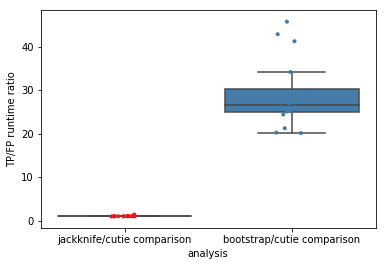

In [48]:
#import matplotlib as plt
%matplotlib inline
import seaborn as sns

x_var = 'analysis'
y_var = 'TP/FP runtime ratio'
sns_plot = sns.boxplot(x=x_var, y=y_var, data=melted_ratio_for_df,showfliers=False,palette="Set1")
sns.stripplot(x=x_var, y=y_var, data=melted_ratio_for_df,
              size=4, jitter=True, edgecolor="gray",palette="Set1")
fig = sns_plot.get_figure()
fig.savefig("/Users/KevinBu/Desktop/clemente_lab/Submissions/CUTIE/for_fold_runtime.pdf")



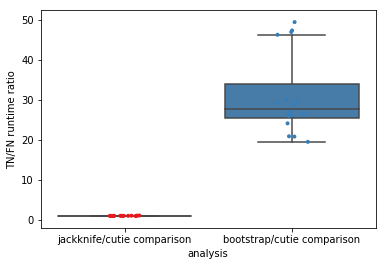

In [49]:
#import matplotlib as plt
%matplotlib inline
import seaborn as sns

x_var = 'analysis'
y_var = 'TN/FN runtime ratio'
sns_plot = sns.boxplot(x=x_var, y=y_var, data=melted_ratio_rev_df,showfliers=False,palette="Set1")
sns.stripplot(x=x_var, y=y_var, data=melted_ratio_rev_df,
              size=4, jitter=True, edgecolor="gray",palette="Set1")
fig = sns_plot.get_figure()
fig.savefig("/Users/KevinBu/Desktop/clemente_lab/Submissions/CUTIE/rev_fold_runtime.pdf")


##### 